# <center>**Engineer Molecular Features**</center>  
**Author**: Shirshak Aryal  
**Last Updated**: 18 July 2025

---
**Purpose:** This notebook focuses on transforming the cleaned molecular SMILES strings into numerical features suitable for machine learning models. This involves the generation of a comprehensive set of RDKit 2D descriptors and Morgan fingerprints, which capture key structural and chemical properties of each molecule, thereby enabling models to learn from the molecular data.

---

## 1. Setup Notebook
This section initializes the notebook environment by importing necessary libraries, configuring system settings, and defining any global parameters relevant to the subsequent feature engineering process.

### 1.1. Configure Environment
This sub-section sets environment variables to optimize CPU core usage for numerical computations, which can be particularly beneficial during feature calculation.

In [1]:
# General CPU Usage Optimization
import os
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"

### 1.2. Import Libraries
All required Python libraries for molecular feature generation, data manipulation, machine learning data preprocessing, and model-specific imports are consolidated and imported here.

In [2]:
# Standard Library Imports
from pathlib import Path

# Core Data Science Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Molecular Feature Generation Libraries
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

# Conditional import for progress bars (tqdm)
tqdm_notebook_available = False  # Initialize flag
try:
    from tqdm.notebook import tqdm

    tqdm.pandas()  # Enable tqdm for pandas apply functions
    tqdm_notebook_available = True
except ImportError:
    print("tqdm.notebook not found. Progress bars will not be displayed.")

### 1.3. Set Feature Engineered Dataset Save Location

In [3]:
features_dir = Path("../data/features")
features_dir.mkdir(parents=True, exist_ok=True)
print(f"The feature-engineered dataset will be saved in: {features_dir}")

The feature-engineered dataset will be saved in: ..\data\features


## 2. Load Cleaned Dataset
This section loads the pre-cleaned molecular bioactivity dataset, containing `molregno`, `canonical_smiles`, `pGI50`, and `num_activities` values, which serves as the input for the feature engineering process.

In [4]:
data_filepath = Path("../data/processed/gi50_final_cleaned_data.csv")

try:
    df = pd.read_csv(data_filepath)
    print(f"Successfully loaded data from: {data_filepath}")
    print(f"Shape of loaded data: {df.shape}")
    display(df.head())
    display(df.info())
except FileNotFoundError:
    print(f"Error: Data file not found at {data_filepath}. Please ensure '00_Build_Clean_Dataset.ipynb' was run and saved the file.")

Successfully loaded data from: ..\data\processed\gi50_final_cleaned_data.csv
Shape of loaded data: (18964, 4)


,molregno,canonical_smiles,pGI50,num_activities
0,148,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,7.999957,1
1,666,Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...,4.823909,1
2,696,Cc1cc(O)nc2c3c(ccc12)OC(C)(C)C=C3,5.421428,7
3,717,CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(...,5.583359,1
4,846,CC1(C)CC(C)(C)c2cc(NC(=S)Nc3ccc([N+](=O)[O-])c...,5.405822,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964 entries, 0 to 18963
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   molregno          18964 non-null  int64  
 1   canonical_smiles  18964 non-null  object 
 2   pGI50             18964 non-null  float64
 3   num_activities    18964 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 592.8+ KB


None

## 3. Perform Exploratory Data Analysis (EDA)
This section conducts initial exploratory data analysis on the loaded cleaned dataset to confirm data integrity and understand the distributions of key variables relevant to feature engineering.

### 3.1. Perform Initial Data Checks
This sub-section reconfirms the dataset's structure and quality after loading.

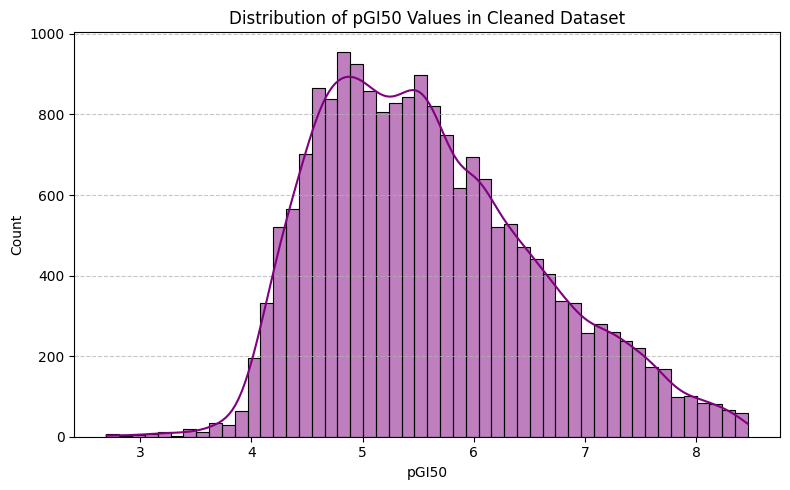


Descriptive statistics of numerical columns:


,molregno,pGI50,num_activities
count,1.896400e+04,18964.000000,18964.000000
mean,1.469810e+06,5.605709,5.678232
std,8.725293e+05,0.988554,11.122305
min,1.480000e+02,2.699000,1.000000
25%,5.755018e+05,4.835585,1.000000
50%,1.557706e+06,5.470846,2.000000
75%,2.281521e+06,6.236571,5.000000
max,2.881183e+06,8.462476,219.000000



Remaining missing values:


Series([], dtype: int64)


Distribution of 'num_activities':


num_activities
1    0.330363
2    0.176756
3    0.147437
4    0.082894
5    0.052731
Name: proportion, dtype: float64

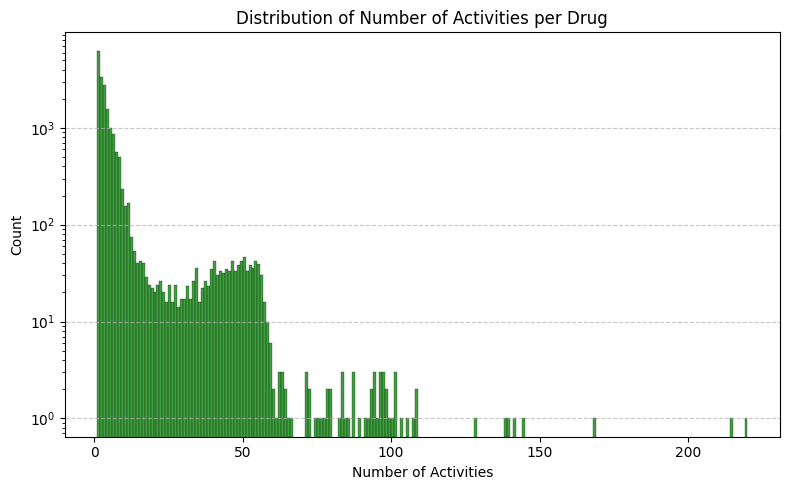

In [5]:
# Re-confirm target variable distribution (pGI50)
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='pGI50', bins=50, kde=True, color='purple')
plt.title('Distribution of pGI50 Values in Cleaned Dataset')
plt.xlabel('pGI50')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Check summary statistics for numerical columns, especially pGI50
print("\nDescriptive statistics of numerical columns:")
display(df.describe())

# Check for any remaining missing value (should be minimal or none)
print("\nRemaining missing values:")
display(df.isnull().sum()[df.isnull().sum() > 0])

# Check num_activities distribution
if 'num_activities' in df.columns:
    print("\nDistribution of 'num_activities':")
    display(df['num_activities'].value_counts(normalize=True).head())

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='num_activities', bins=range(1, df['num_activities'].max() + 2), kde=False, color='green')
    plt.title('Distribution of Number of Activities per Drug')
    plt.xlabel('Number of Activities')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 4. Engineer Features
This section transforms the molecular SMILES strings into a comprehensive set of numerical features that can be used by machine learning models.

### 4.1. Generate RDKit Descriptors
This sub-section generates a wide range of RDKit 2D physicochemical properties, topological descriptors, counts (e.g., number of atoms, bonds, rings), etc. for each molecule based on its SMILES string.

In [6]:
print("Starting molecular feature generation from SMILES...")

def generate_all_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Return a list of NaNs for all descriptors if SMILES is invalid
        return [np.nan] * len(Descriptors._descList)
    else:
        # Descriptors._descList contains (name, function) tuples
        return [descriptor[1](mol) for descriptor in Descriptors._descList]

# Get the list of all RDKit descriptor names
all_rdkit_descriptor_names = [descriptor[0] for descriptor in Descriptors._descList]

print(f"Generating {len(all_rdkit_descriptor_names)} RDKit physicochemical descriptors...")
if tqdm_notebook_available:
    rdkit_desc_values = df['canonical_smiles'].progress_apply(generate_all_rdkit_descriptors)
else:
    rdkit_desc_values = df['canonical_smiles'].apply(generate_all_rdkit_descriptors)

# Convert the list of lists into a DataFrame
rdkit_desc_df = pd.DataFrame(rdkit_desc_values.tolist(), columns=all_rdkit_descriptor_names, index=df.index)
print("RDKit physicochemical descriptors generated.")
display(rdkit_desc_df.head())

Starting molecular feature generation from SMILES...
Generating 217 RDKit physicochemical descriptors...


  0%|          | 0/18964 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 4.2. Generate Morgan Fingerprints
This sub-section creates Morgan fingerprints (a type of circular structural fingerprint) for each molecule. These fingerprints represent structural patterns as bit vectors.

In [ ]:
fingerprint_radius = 2
fingerprint_nBits = 2048

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=fingerprint_radius, fpSize=fingerprint_nBits)

def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Return a list of zeros for the fingerprint if SMILES is invalid
        return [0] * fingerprint_nBits
    else:
        fp = morgan_gen.GetFingerprint(mol)
        return list(fp) # Convert ExplicitBitVect to a list of integers

print(f"\nGenerating Morgan Fingerprints (Radius={fingerprint_radius}, nBits={fingerprint_nBits})...")
if tqdm_notebook_available:
    morgan_fp_values = df['canonical_smiles'].progress_apply(generate_morgan_fp)
else:
    morgan_fp_values = df['canonical_smiles'].apply(generate_morgan_fp)

# Convert the list of lists into a DataFrame
morgan_fp_df = pd.DataFrame(morgan_fp_values.tolist(),
                            columns=[f'morgan_fp_{i}' for i in range(fingerprint_nBits)],
                            index=df.index)
print("Morgan Fingerprints generated.")
display(morgan_fp_df.head())


Generating Morgan Fingerprints (Radius=2, nBits=2048)...


  0%|          | 0/18964 [00:00<?, ?it/s]

[17:23:21] Explicit valence for atom # 34 P, 7, is greater than permitted


Morgan Fingerprints generated.


,morgan_fp_0,morgan_fp_1,morgan_fp_2,morgan_fp_3,morgan_fp_4,morgan_fp_5,morgan_fp_6,morgan_fp_7,morgan_fp_8,morgan_fp_9,...,morgan_fp_2038,morgan_fp_2039,morgan_fp_2040,morgan_fp_2041,morgan_fp_2042,morgan_fp_2043,morgan_fp_2044,morgan_fp_2045,morgan_fp_2046,morgan_fp_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.3. Combine Generated Features
The independently generated RDKit descriptors and Morgan fingerprints are concatenated to form a single, comprehensive feature matrix for the dataset.

In [ ]:
features_df = df[['molregno', 'pGI50', 'canonical_smiles']].copy() # Keep SMILES for reference

# Conditionally add 'num_activities' if it exists in the original df
if 'num_activities' in df.columns:
    features_df['num_activities'] = df['num_activities']

# Concatenate the generated RDKit descriptors and Morgan fingerprints
features_df = pd.concat([features_df, rdkit_desc_df, morgan_fp_df], axis=1)

# Handle any NaN values generated
initial_rows_before_feature_dropna = features_df.shape[0]
features_df.dropna(inplace=True)
rows_after_feature_dropna = features_df.shape[0]

if initial_rows_before_feature_dropna != rows_after_feature_dropna:
    rows_removed_due_to_nan = initial_rows_before_feature_dropna - rows_after_feature_dropna
    print(f"\nWarning: Dropped {rows_removed_due_to_nan} rows due to NaN values in generated features (e.g., from invalid SMILES).")
    print(f"New DataFrame shape after feature NaN drop: {features_df.shape}")



New DataFrame shape after feature NaN drop: (18743, 2269)


## 5. Refine Engineered Features (Iterative)
This section includes iterative steps for further refining the generated features, ensuring they are optimized for model training. This process might be revisited based on model performance or feature analysis.

**NOTE**: At the time of updating this notebook, this section only refines the `Ipc` column, which is one of the features previously generated using RDKit.

### 5.1. Visualize Feature Distributions
Histograms and other plots are generated to visualize the distribution of individual features, helping to identify skewness, outliers, or other distributional issues.

NameError: name 'features_df' is not defined

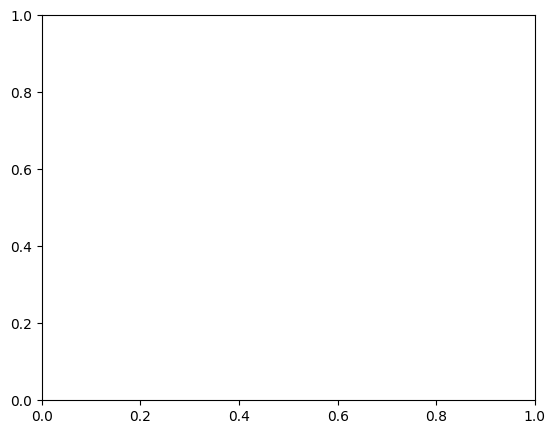

In [7]:
plt.figure(figsize=(14, 5))

# Subplot 1: Original 'Ipc' distribution
plt.subplot(1, 2, 1)
sns.histplot(features_df['Ipc'], bins=50, kde=True)
plt.title('Original Distribution of Ipc')
plt.xlabel('Ipc Value')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.ylim(bottom=1) # Ensure y-axis starts at 1 for log scale

# Subplot 2: Log-transformed 'Ipc' distribution
plt.subplot(1, 2, 2)
# Filter out any non-positive values (Ipc should be non-negative)
sns.histplot(np.log1p(features_df['Ipc']), bins=50, kde=True)
plt.title('Log1p-Transformed Distribution of Ipc')
plt.xlabel('log1p(Ipc) Value')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\n--- Descriptive Statistics for Ipc (Original Values) ---")
display(features_df['Ipc'].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99, .999]))

print("\n--- Data points with highest Ipc values ---")
display(features_df['Ipc'].nlargest(10)) # Show top 10 largest values

print(f"\n--- Skewness of Ipc (Original Values) ---\n{features_df['Ipc'].skew()}")

log_scaled_ipc = np.log1p(features_df['Ipc'])
print(f"\n--- Skewness of Ipc (Log1p-Scaled Values) ---\n{log_scaled_ipc.skew()}")

### 5.2. Handle Feature-Specific Issues
This sub-section addresses the extreme values seen in the `Ipc` column by capping them to a slightly lower max value.

In [12]:
IPC_CAP_VALUE = 1e15

print(f"Checking 'Ipc' feature for values exceeding cap of {IPC_CAP_VALUE:.0e}...")

original_max_ipc = features_df['Ipc'].max()
num_values_to_cap = (features_df['Ipc'] > IPC_CAP_VALUE).sum()

print(f"Original max 'Ipc' value: {original_max_ipc:.2e}")

if num_values_to_cap > 0:
    print(f"WARNING: Found {num_values_to_cap} 'Ipc' values to cap.")
    # Apply the capping using .clip() method
    features_df['Ipc'] = features_df['Ipc'].clip(upper=IPC_CAP_VALUE)
    print(f"Max 'Ipc' value after capping: {features_df['Ipc'].max():.2e}")
else:
    print("No 'Ipc' values found exceeding the cap. No capping applied.")

Checking 'Ipc' feature for values exceeding cap of 1e+15...
Original max 'Ipc' value: 1.22e+88
Max 'Ipc' value after capping: 1.00e+15


## 6. Check For and Handle Any Generated Missing Values
A final check for any `NaN` values that might have been generated during the feature engineering process (e.g., for molecules RDKit couldn't process) is performed, and these rows are dropped or imputed as appropriate.

In [13]:
initial_rows_before_feature_dropna = features_df.shape[0]
features_df.dropna(inplace=True)
rows_after_feature_dropna = features_df.shape[0]

if initial_rows_before_feature_dropna != rows_after_feature_dropna:
    rows_removed_due_to_nan = initial_rows_before_feature_dropna - rows_after_feature_dropna
    print(f"\nWarning: Dropped {rows_removed_due_to_nan} rows due to NaN values in generated features (e.g., from invalid SMILES).")
    print(f"New DataFrame shape after feature NaN drop: {features_df.shape}")

## 7. Save Feature Engineered Dataset
The final, fully engineered dataset containing all molecular features and the target variable is saved locally to ensure it is readily available for the subsequent data splitting and model training notebooks.

In [14]:
# Save this feature engineered dataset
print(f"\nSaving fully feature-engineered DataFrame to {features_dir}...")
features_df.to_parquet(features_dir / "gi50_features.parquet", index=False)
print("Fully feature-engineered DataFrame saved successfully.")

print("\nFeature engineering complete.")


Saving fully feature-engineered DataFrame to ..\data\features...
Fully feature-engineered DataFrame saved successfully.

Feature engineering complete.
